<a href="https://colab.research.google.com/github/SaadTazroute/FrenchLegalNLP/blob/master/01_TF_IDF_JURISPRUDENCE_%2B_Traitement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
np.set_printoptions(precision=3)
# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [12]:
import re
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Prepare data

## Load dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')















Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:

path='/content/drive/My Drive/Freemium02.csv'
import pandas as pd
data_df = pd.read_csv(path, error_bad_lines=False)
data_df=data_df.dropna(how = 'any')
data_df=data_df[:10000]


#data_df = data_df.drop('idx', 1)

data_df.head(2)



data_df = pd.DataFrame({'content':data_df['content'],'solution':data_df['solution']})
data_df['solution']=data_df['solution'].str.lower()
data_df







,content,solution
0,"ANNULATION , sur la demande du sieur Prosper X...",annulation
1,REJET du pourvoi formé par le sieur Y ... et c...,rejet
2,"ANNULATION , sur la demande des sieurs G ... d...",annulation
3,"ANNULATION , sur la demande des héritiers de l...",annulation
4,"ANNULATION , sur la demande de M . le Procureu...",annulation
...,...,...
11340,SUR LE MOYEN UNIQUE : ATTENDU QU ' IL RESULTE ...,rejet
11341,"SUR LE PREMIER MOYEN , PRIS EN SES DEUX BRANCH...",rejet
11342,SUR LE MOYEN UNIQUE : VU L ' ARTICLE 474 DU CO...,cassation
11343,SUR LE MOYEN UNIQUE : ATTENDU QU ' UN JUGEMENT...,rejet


In [2]:
resultat = data_df.groupby('solution')['content'].nunique()
resultat

solution
annulation          35
cassation         3260
irrecevabilite     218
rejet             6486
Name: content, dtype: int64

In [3]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[250:500]
      l_total.append(" ".join(l_parcial))
  return l_total

In [4]:
data_df['content'] = data_df['content'].apply(get_split)
data_df['content']=data_df['content'].astype(str)

data_df.head()

,content,solution
0,"[""envers les sieurs A ... et B ..., d ' une so...",annulation
1,"[""Paris , le 4 septembre 1841 , époque à laque...",rejet
2,"[""restait due , d ' acquitter à l ' hospice de...",annulation
3,"[""aux donations faites entre époux par contrat...",annulation
4,"[""général , en ses conclusions ; après en avoi...",annulation


In [5]:
seuil=20
data_df = data_df[data_df.groupby('solution').solution.transform('count')>seuil].copy() 
data_df
resultat = data_df.groupby('solution')['content'].nunique()
resultat


solution
annulation          35
cassation         3195
irrecevabilite     125
rejet             6265
Name: content, dtype: int64

In [6]:
corpus_docs = []
n = len(data_df)
corpus_docs = corpus_docs + data_df.iloc[:,0].tolist()
corpus_labels = list(data_df['solution'])

In [7]:
corpus_labels[0:2],corpus_docs[0:2]

(['annulation', 'rejet'],
 ['["envers les sieurs A ... et B ..., d \' une somme de 79000 francs , qu \' il paraît compter à l \' instant au sieur Y ..., lequel , à son tour , passa quittance définitive du prix de l \' office à X .... Les qualités de l \' arrêt attaqué constatent que X ... paya , pendant neuf mois , les intérêts du capital de 79000 francs prêté par les sieurs A ... et B ..., en sorte que l \' exécution des deux traités du 13 avril 1838 semble avoir été entière . Mais , le 22 janvier 1841 , X ... assigna devant le tribunal de Rouen , tant Y ..., son vendeur , que les sieurs A ... et B ..., cessionnaires de celui - ci , pour voir dire , Y ..., que , sans égard aux conventions particulières , le prix de l \' office serait réduit et maintenu aux 85000 francs énoncés dans l \' acte ostensible , si mieux n \' aimait Y ... le voir résilié ... etc ., et les sieurs A ... et B ..., pour voir déclarer commun avec eux le jugement à intervenir . Le 18 juillet 1841 , jugement du trib

In [8]:
data_df['category_id'] = data_df['solution'].factorize()[0]
category_id_df = data_df[['solution', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'solution']].values)

# New dataframe
data_df.head()

,content,solution,category_id
0,"[""envers les sieurs A ... et B ..., d ' une so...",annulation,0
1,"[""Paris , le 4 septembre 1841 , époque à laque...",rejet,1
2,"[""restait due , d ' acquitter à l ' hospice de...",annulation,0
3,"[""aux donations faites entre époux par contrat...",annulation,0
4,"[""général , en ses conclusions ; après en avoi...",annulation,0


## TFIDF

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.




## TF-IDF

****### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [13]:




tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2))

# We transform each complaint into a vector
features = tfidf.fit_transform(data_df.content).toarray()

labels = data_df.category_id

print("Chacune des %d  jurisprudences est représentée par %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))







    
    
    


Chacune des 10000  jurisprudences est représentée par 37453 features (TF-IDF score of unigrams and bigrams)


In [14]:
# Finding the three most correlated terms with each of the product categories
N = 10
for solution, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(solution))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    
    
    
    


==> annulation:
  * Most Correlated Unigrams are: défaut, 1733, même, défendeurs, violé, arrêt, été, prononcé, jugé, napoléon
  * Most Correlated Bigrams are: ont été, du même, en déclarant, prononcé chambre, et prononcé, violé les, jugé chambre, ainsi jugé, du napoléon, casse ainsi

==> cassation:
  * Most Correlated Unigrams are: consequence, avant, ledit, elles, casse, annule, parties, remet, semblable, renvoie
  * Most Correlated Bigrams are: et semblable, semblable etat, fait droit, etaient avant, pour etre, etre fait, droit les, les renvoie, renvoie devant, les parties

==> irrecevabilite:
  * Most Correlated Unigrams are: 228, 184, 413, 592, 345, brumaire, arrets, cites, 393, irrecevable
  * Most Correlated Bigrams are: ii 246, cassation declare, declare irrecevable, attaquee en, pourvoi irrecevable, etre attaquee, declare en, consequence irrecevable, motifs declare, irrecevable le

==> rejet:
  * Most Correlated Unigrams are: avant, ledit, consequence, elles, parties, annule, 

## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

In [15]:
X = data_df['content'] # Collection of documents
y = data_df['solution'] # Target or the labels we want to predict 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

MODELS

In [16]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.9073,0.015991
LogisticRegression,0.8912,0.014682
MultinomialNB,0.8540,0.016685
RandomForestClassifier,0.8422,0.020373


In [18]:
## Model evaluation

In [19]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               data_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= data_df['solution'].unique()))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

    annulation       1.00      0.17      0.29        12
         rejet       0.90      0.99      0.94      1629
     cassation       0.95      0.82      0.88       806
irrecevabilite       0.92      0.21      0.34        53

      accuracy                           0.91      2500
     macro avg       0.94      0.55      0.61      2500
  weighted avg       0.92      0.91      0.91      2500



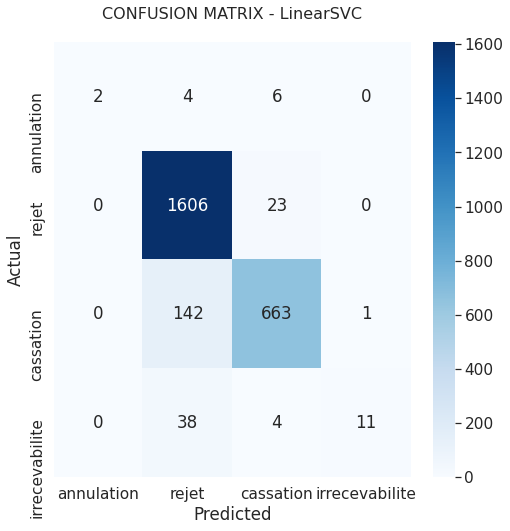

In [21]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.solution.values, 
            yticklabels=category_id_df.solution.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);